In [1]:
# Input:
path_data = '../../01 data/train_pollution.csv'
n_lag = 4

path_01 = '../../03 outputs/multivariate/01/'
path_scaler = path_01 + 'time_scaler.pickle'
path_x_train = path_01 + 'X_train_lag4.npy'
path_y_train = path_01 + 'y_train_lag4.npy'
path_x_val = path_01 + 'X_val_lag4.npy'
path_y_val = path_01 + 'y_val_lag4.npy'
path_x_test = path_01 + 'X_test_lag4.npy'
path_y_test = path_01 + 'y_test_lag4.npy'

path_02 = '../../03 outputs/multivariate/02/'
path_forecaster_cnn_lstm = path_02 + 'forecaster_cnn_lstm.hdf5'
path_forecaster_conv_lstm = path_02 + 'forecaster_conv_lstm.hdf5'

n_features = 6
n_seq = 2
n_steps = 2
dimension = 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error
import pickle
from keras.models import load_model

In [3]:
# Convert to datetime
def date_parser(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# Load data
data = pd.read_csv(path_data)
data['date_time'] = data['date_time'].apply(date_parser)
data = data[
    ['target_carbon_monoxide', 'sensor_1', 'sensor_2', 'sensor_5', 'target_benzene', 'target_nitrogen_oxides']
]
data = data.loc[n_lag:, :]
print(data.shape)
data.head(3)

(7107, 6)


,target_carbon_monoxide,sensor_1,sensor_2,sensor_5,target_benzene,target_nitrogen_oxides
4,1.5,1272.0,852.7,1132.2,6.4,121.8
5,1.2,1220.9,697.5,949.0,4.4,88.1
6,1.2,1244.2,669.3,769.6,3.7,59.5


In [4]:
# Load data (lag 4 steps)
X_train = np.load(open(path_x_train, 'rb'))
y_train = np.load(open(path_y_train, 'rb'))
X_val = np.load(open(path_x_val, 'rb'))
y_val = np.load(open(path_y_val, 'rb'))
X_test = np.load(open(path_x_test, 'rb'))
y_test = np.load(open(path_y_test, 'rb'))

In [18]:
# Load model and tokenizer
scaler = pickle.load(open(path_scaler, 'rb'))

forecaster_cnn = load_model(path_forecaster_cnn_lstm)
forecaster_conv = load_model(path_forecaster_conv_lstm)

# CNN LSTM

In [6]:
def invert_transform_pred_cnn(pred, X_):
    # Invert the prediction scaling
    inv_X = X_.reshape((X_.shape[0], X_.shape[1] * X_.shape[2] * X_.shape[3]))
    inv_X = np.concatenate((pred, inv_X[:, -n_features+1:]), axis=1)
    inv_X = scaler.inverse_transform(inv_X)
    inv_pred = inv_X[:,0]

    return inv_pred

In [7]:
# Reshape the X_train to have subsequences
X_train_cnn = X_train.reshape((X_train.shape[0], n_seq, n_steps, n_features))
X_val_cnn = X_val.reshape((X_val.shape[0], n_seq, n_steps, n_features))
X_test_cnn = X_test.reshape((X_test.shape[0], n_seq, n_steps, n_features))

In [20]:
# Forecast train
pred_train_cnn = forecaster_cnn.predict(X_train_cnn, verbose=0)
pred_train_cnn = invert_transform_pred_cnn(pred_train_cnn, X_train_cnn)

# Forecast val
pred_val_cnn = forecaster_cnn.predict(X_val_cnn, verbose=0)
pred_val_cnn = invert_transform_pred_cnn(pred_val_cnn, X_val_cnn)

# Forecast test
pred_test_cnn = forecaster_cnn.predict(X_test_cnn, verbose=0)
pred_test_cnn = invert_transform_pred_cnn(pred_test_cnn, X_test_cnn)

In [24]:
# Combine predictions
pred_train_cnn = pd.DataFrame(pred_train_cnn, columns=['prediction'])
pred_train_cnn['split'] = 'train'

pred_val_cnn = pd.DataFrame(pred_val_cnn, columns=['prediction'])
pred_val_cnn['split'] = 'val'

pred_test_cnn = pd.DataFrame(pred_test_cnn, columns=['prediction'])
pred_test_cnn['split'] = 'test'

pred_cnn = pd.concat([pred_train_cnn, pred_val_cnn, pred_test_cnn], axis=0).reset_index(drop=True)
pred_cnn.index = pred_cnn.index + n_lag

# Combine with original data
pred_cnn = pd.concat([data['target_carbon_monoxide'], pred_cnn], axis=1)
print(pred_cnn.shape)
pred_cnn.head(3)

(7107, 3)


,target_carbon_monoxide,prediction,split
4,1.5,2.090003,train
5,1.2,1.965482,train
6,1.2,1.341335,train


In [25]:
# Check the split boundary
train_split = pred_cnn[pred_cnn['split']=='train'].index[-1]
val_split = pred_cnn[pred_cnn['split']=='val'].index[-1]
print(train_split, val_split)

4622 5689


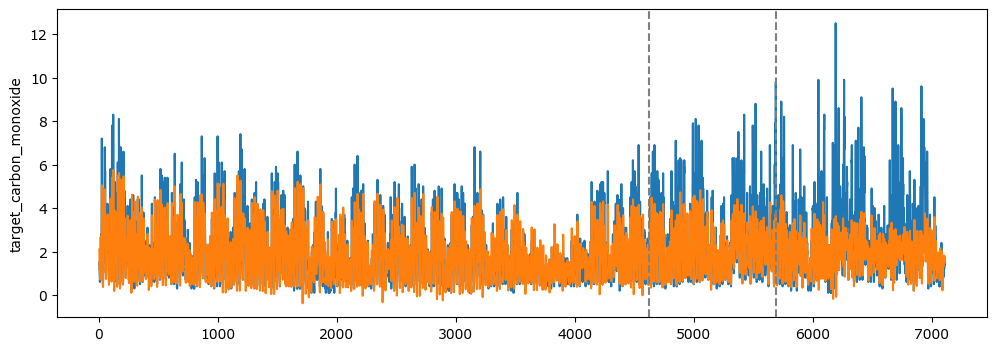

In [26]:
# Plot
plt.figure(figsize=(12,4))
sns.lineplot(pred_cnn, x=pred_cnn.index, y='target_carbon_monoxide')
sns.lineplot(pred_cnn, x=pred_cnn.index, y='prediction')
plt.axvline(train_split, linestyle='--', color='grey')
plt.axvline(val_split, linestyle='--', color='grey')
plt.show()

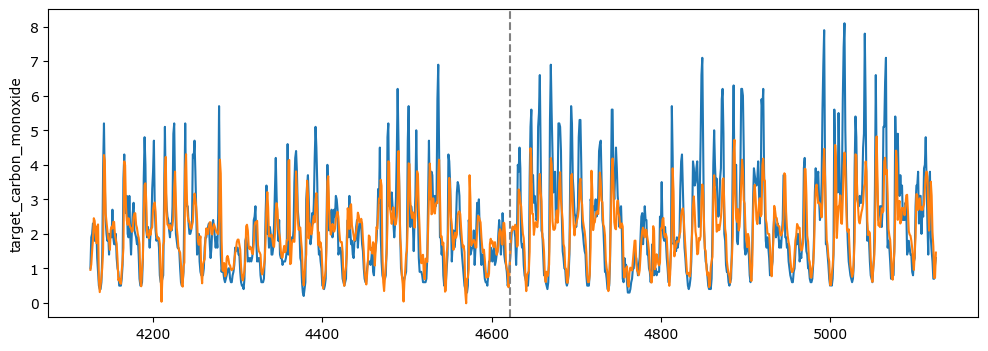

In [27]:
# Plot partial
plt.figure(figsize=(12,4))
sns.lineplot(pred_cnn.iloc[train_split-500:train_split+500,:], x=pred_cnn.iloc[train_split-500:train_split+500,:].index, y='target_carbon_monoxide')
sns.lineplot(pred_cnn.iloc[train_split-500:train_split+500,:], x=pred_cnn.iloc[train_split-500:train_split+500,:].index, y='prediction')
plt.axvline(train_split, linestyle='--', color='grey')
plt.show()

In [28]:
# Accuracy
mae_train = round(mean_absolute_error(pred_cnn.loc[pred_cnn['split']=='train', 'target_carbon_monoxide'], pred_cnn.loc[pred_cnn['split']=='train', 'prediction']), 4)
mae_val = round(mean_absolute_error(pred_cnn.loc[pred_cnn['split']=='val', 'target_carbon_monoxide'], pred_cnn.loc[pred_cnn['split']=='val', 'prediction']), 4)
mae_test = round(mean_absolute_error(pred_cnn.loc[pred_cnn['split']=='test', 'target_carbon_monoxide'], pred_cnn.loc[pred_cnn['split']=='test', 'prediction']), 4)
print(f'training MAE: {mae_train}')
print(f'validation MAE: {mae_val}')
print(f'testing MAE: {mae_test}')

training MAE: 0.4893
validation MAE: 0.7623
testing MAE: 1.0477


In [29]:
# Save
pred_cnn.to_csv('../../03 outputs/multivariate/03/prediction_cnn_lstm.csv')

# Stacked LSTM

In [25]:
def invert_transform_pred_conv(pred, X_):
    # Invert the prediction scaling
    inv_X = X_.reshape((X_.shape[0], X_.shape[1] * X_.shape[2] * X_.shape[3] * X_.shape[4]))
    inv_X = np.concatenate((pred, inv_X[:, -n_features+1:]), axis=1)
    inv_X = scaler.inverse_transform(inv_X)
    inv_pred = inv_X[:,0]

    return inv_pred

In [17]:
# Reshape the X_train into [samples, subsequences, dimension, timesteps, features]
X_train_conv = X_train.reshape((X_train.shape[0], n_seq, dimension, n_steps, n_features))
X_val_conv = X_val.reshape((X_val.shape[0], n_seq, dimension, n_steps, n_features))
X_test_conv = X_test.reshape((X_test.shape[0], n_seq, dimension, n_steps, n_features))

In [26]:
# Forecast train
pred_train_conv = forecaster_conv.predict(X_train_conv, verbose=0)
pred_train_conv = invert_transform_pred_conv(pred_train_conv, X_train_conv)

# Forecast val
pred_val_conv = forecaster_conv.predict(X_val_conv, verbose=0)
pred_val_conv = invert_transform_pred_conv(pred_val_conv, X_val_conv)

# Forecast test
pred_test_conv = forecaster_conv.predict(X_test_conv, verbose=0)
pred_test_conv = invert_transform_pred_conv(pred_test_conv, X_test_conv)

In [27]:
# Combine predictions
pred_train_conv = pd.DataFrame(pred_train_conv, columns=['prediction'])
pred_train_conv['split'] = 'train'

pred_val_conv = pd.DataFrame(pred_val_conv, columns=['prediction'])
pred_val_conv['split'] = 'val'

pred_test_conv = pd.DataFrame(pred_test_conv, columns=['prediction'])
pred_test_conv['split'] = 'test'

pred_conv = pd.concat([pred_train_conv, pred_val_conv, pred_test_conv], axis=0).reset_index(drop=True)
pred_conv.index = pred_conv.index + n_lag

# Combine with original data
pred_conv = pd.concat([data['target_carbon_monoxide'], pred_conv], axis=1)
print(pred_conv.shape)
pred_conv.head(3)

(7107, 3)


,target_carbon_monoxide,prediction,split
4,1.5,2.251602,train
5,1.2,1.695938,train
6,1.2,1.266550,train


In [28]:
# Check the split boundary
train_split = pred_conv[pred_conv['split']=='train'].index[-1]
val_split = pred_conv[pred_conv['split']=='val'].index[-1]
print(train_split, val_split)

4622 5689


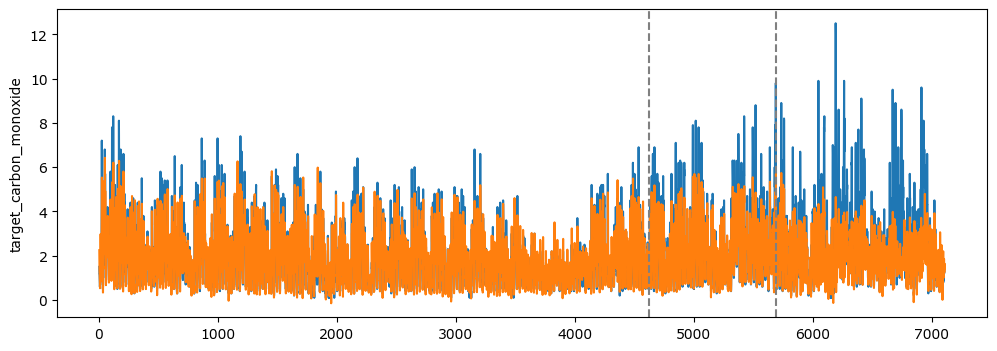

In [29]:
# Plot
plt.figure(figsize=(12,4))
sns.lineplot(pred_conv, x=pred_conv.index, y='target_carbon_monoxide')
sns.lineplot(pred_conv, x=pred_conv.index, y='prediction')
plt.axvline(train_split, linestyle='--', color='grey')
plt.axvline(val_split, linestyle='--', color='grey')
plt.show()

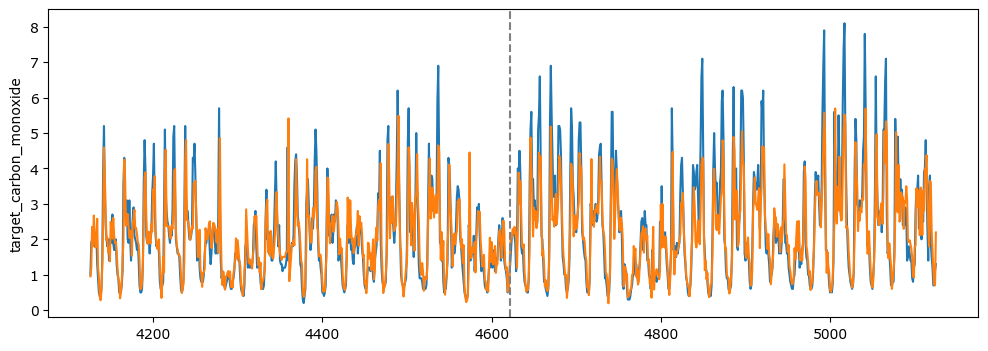

In [30]:
# Plot partial
plt.figure(figsize=(12,4))
sns.lineplot(pred_conv.iloc[train_split-500:train_split+500,:], x=pred_conv.iloc[train_split-500:train_split+500,:].index, y='target_carbon_monoxide')
sns.lineplot(pred_conv.iloc[train_split-500:train_split+500,:], x=pred_conv.iloc[train_split-500:train_split+500,:].index, y='prediction')
plt.axvline(train_split, linestyle='--', color='grey')
plt.show()

In [31]:
# Accuracy
mae_train = round(mean_absolute_error(pred_conv.loc[pred_conv['split']=='train', 'target_carbon_monoxide'], pred_conv.loc[pred_conv['split']=='train', 'prediction']), 4)
mae_val = round(mean_absolute_error(pred_conv.loc[pred_conv['split']=='val', 'target_carbon_monoxide'], pred_conv.loc[pred_conv['split']=='val', 'prediction']), 4)
mae_test = round(mean_absolute_error(pred_conv.loc[pred_conv['split']=='test', 'target_carbon_monoxide'], pred_conv.loc[pred_conv['split']=='test', 'prediction']), 4)
print(f'training MAE: {mae_train}')
print(f'validation MAE: {mae_val}')
print(f'testing MAE: {mae_test}')

training MAE: 0.4123
validation MAE: 0.5961
testing MAE: 0.9303


In [32]:
# Save
pred_conv.to_csv('../../03 outputs/multivariate/03/prediction_conv_lstm.csv')